# バンディッド問題

In [1]:
# サンプル平均を計算する
import numpy as np

np.random.seed(0)
rs = []

for n in range(1, 11):
    r = np.random.rand()
    rs.append(r)
    q = sum(rs) / n
    print(q)

0.5488135039273248
0.6320014351498722
0.6222554154571295
0.6029123573420713
0.567060845741438
0.5801997236289743
0.5598265075766483
0.6013198192273272
0.6415801460355164
0.6157662833145425


In [2]:
# メモリを使わないように計算
q = 0
for n in range(1, 11):
    r = np.random.rand()
    q = q + (r - q) / n
    print(q)

0.7917250380826646
0.6603099789177845
0.6295548396431672
0.7035652893055406
0.5770594430840099
0.49540441918693173
0.4275207017945595
0.4781580947637318
0.5114912787844116
0.5473433657306523


# バンディッドアルゴリズムの実装

###### スロットマシンの実装

In [3]:
class Bandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.rates = np.random.rand(arms) # 勝率を設定

    def play(self, arm):
        rate = self.rates[arm] # 勝率を取得
        reward = rate > np.random.rand() # 勝った場合Trueになる
        return int(reward) # Trueを1に変換

In [4]:
bandit = Bandit()

for i in range(3):
    print(bandit.play(0))

1
1
1


###### エージェントの実装

In [5]:
bandit = Bandit()
qs = np.zeros(10) # 価値の推定値を格納
ns = np.zeros(10) # スロットマシンをプレイした回数を格納

for n in range(10):
    a = np.random.randint(0, 10)  # ランダムな行動
    r = bandit.play(a)

    ns[a] += 1
    qs[a] += (r - qs[a]) / ns[a] # 前節の計算を使用
    print(qs) # それぞれのスロットマシンの価値の推定値を出力

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
[0.  0.  1.  1.  0.  0.  1.  0.  0.  0.5]
[0.  0.  1.  1.  0.  0.  1.  0.  0.  0.5]
[0.  0.  1.  1.  0.5 0.  1.  0.  0.  0.5]
[0.         0.         1.         1.         0.66666667 0.
 1.         0.         0.         0.5       ]
[0.   0.   1.   1.   0.75 0.   1.   0.   0.   0.5 ]
[0.   0.   1.   1.   0.75 0.   1.   1.   0.   0.5 ]


In [6]:
# イプシロン・グリーディで実装
class Agent:
    def __init__(self, epsilon, action_size=10):
        self.epsilon = epsilon
        self.qs = np.zeros(action_size)
        self.ns = np.zeros(action_size)

    # スロットマシンの価値の推定
    def update(self, action, reward):
        a, r = action, reward  # これ以降の記述を短くするため一文字(a, r)で参照
        self.ns[a] += 1
        self.qs[a] += (r - self.qs[a]) / self.ns[a]

    # 行動を選択
    def get_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, len(self.qs))
        return np.argmax(self.qs)

###### 実際に動かしてみる

In [7]:
steps = 1000
epsilon = 0.1

bandit = Bandit()
agent = Agent(epsilon)
sum_r = 0 # 報酬の合計
total_rewards = []
rates = []

for step in range(steps):
    action = agent.get_action()   # ① 行動を選ぶ
    reward = bandit.play(action)  # ② 実際にプレイして報酬を得る
    agent.update(action, reward)  # ③ 行動と報酬から学ぶ
    sum_r += reward

    total_rewards.append(sum_r)
    rates.append(sum_r / (step+1))

print(sum_r)

# グラフの描画(1)
import matplotlib.pyplot as plt  # matplotlibのインポート
plt.ylabel('Total reward')
plt.xlabel('Steps')
plt.plot(total_rewards)
plt.show()
# グラフの描画(2)
plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(rates)
plt.show()

932


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

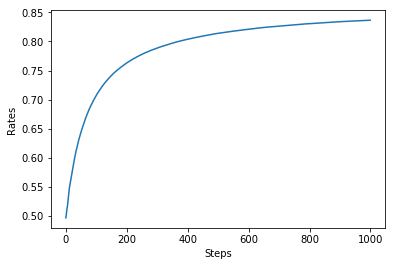

In [8]:
# 1回の実験ではわからないので、2000回実験を行う
runs = 2000
steps = 1000
epsilon = 0.1
all_rates = np.zeros((runs, steps))  # (2000, 1000)の形状の配列

for run in range(runs):  # 2000回の実験
    bandit = Bandit()
    agent = Agent(epsilon)
    sum_r = 0
    rates = []

    for step in range(steps):
        action = agent.get_action()
        reward = bandit.play(action)
        agent.update(action, reward)
        sum_r += reward
        rates.append(sum_r / (step+1))

    all_rates[run] = rates  # ①報酬の結果を記録する

avg_rates = np.average(all_rates, axis=0)  # ②各ステップにおける平均を求める

# グラフの描画
plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(avg_rates)
plt.show()

# 非定常問題

In [9]:
class NonStatBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.rates = np.random.rand(arms)

    def play(self, arm):
        rate = self.rates[arm]
        reward = rate > np.random.rand()
        # ノイズを追加
        self.rates += 0.1 * np.random.randn(self.arms)
        return int(reward)

###### 非定常問題を解く

In [10]:
# サンプル平均ではなくて、固定値アルファで更新していく（過去の重みを下げるため）
class AlphaAgent:
    def __init__(self, epsilon, alpha, actions=10):
        self.epsilon = epsilon
        self.qs = np.zeros(actions)
        self.alpha = alpha

    def update(self, action, reward):
        a, r = action, reward
        self.qs[a] += (r - self.qs[a]) * self.alpha  # alphaで更新

    def get_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, len(self.qs))
        return np.argmax(self.qs)

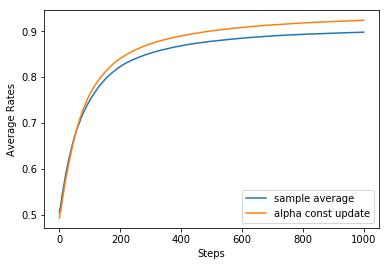

In [11]:
runs = 2000
steps = 1000
epsilon = 0.1
alpha = 0.8
agent_types = ['sample average', 'alpha const update']
results = {}

for agent_type in agent_types:
    all_rates = np.zeros((runs, steps))  # (2000, 1000)

    for run in range(runs):
        if agent_type == 'sample average':
            agent = Agent(epsilon)
        else:
            agent = AlphaAgent(epsilon, alpha)

        bandit = NonStatBandit()
        sum_r = 0
        rates = []

        for step in range(steps):
            action = agent.get_action()
            reward = bandit.play(action)
            agent.update(action, reward)
            sum_r += reward
            rates.append(sum_r / (step+1))

        all_rates[run] = rates

    avg_rates = np.average(all_rates, axis=0)
    results[agent_type] = avg_rates

# plot
plt.figure()
plt.ylabel('Average Rates')
plt.xlabel('Steps')
for key, avg_rates in results.items():
    plt.plot(avg_rates, label=key)
plt.legend()
plt.show()